In [1]:
!pip install mistralai==0.0.12 seaborn numpy scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00


In [2]:
from mistralai.client import MistralClient

client = MistralClient(api_key="rrXMIjg4zKH2qCYv7jRPVVgYYuMMbfnt")

embeddings_batch_response = client.embeddings(
    model="mistral-embed",
    input=["Embed this sentence.", "As well as this one."],
  )

In [3]:
len(embeddings_batch_response.data[0].embedding)

1024

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
          model="mistral-embed",
          input=input
      )
    return embeddings_batch_response.data[0].embedding

In [5]:
sentences = [
    "A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title?",
    "I think books are like people, in the sense that they’ll turn up in your life when you most need them"
]
embeddings = [get_text_embedding(t) for t in sentences]

In [6]:
reference_sentence = "Books are mirrors: You only see in them what you already have inside you"
reference_embedding = get_text_embedding(reference_sentence)

In [7]:
for t, e in zip(sentences, embeddings):
    distance = euclidean_distances([e], [reference_embedding])
    print(t, distance)

A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title? [[0.80094257]]
I think books are like people, in the sense that they’ll turn up in your life when you most need them [[0.58162089]]


In [8]:
sentences = [
    'Have a safe happy Memorial Day weekend everyone',
    'To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend',
    'Where can I find the best cheese?'
]

In [9]:
sentence_embeddings = [get_text_embedding(t) for t in sentences]

In [10]:
import itertools

sentence_embeddings_pairs = list(itertools.combinations(sentence_embeddings, 2))
sentence_pairs = list(itertools.combinations(sentences, 2))

In [11]:
for s, e in zip(sentence_pairs, sentence_embeddings_pairs):
    print(s, euclidean_distances([e[0]], [e[1]]))

('Have a safe happy Memorial Day weekend everyone', 'To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend') [[0.54326686]]
('Have a safe happy Memorial Day weekend everyone', 'Where can I find the best cheese?') [[0.92573978]]
('To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend', 'Where can I find the best cheese?') [[0.9114184]]


HERE I HAVE USED ANOTHER DATASET FROM KAGGLE (REPRESENTING DIFFERENT DIFFERENT EMOTION) RATHER THAN PROVIDED IN THE DOCUMENTATION CODE..


In [26]:
import pandas as pd

df = pd.read_csv("/content/emotions.csv", index_col=0)
label_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

df['label'] = df['label'].map(label_mapping)


In [27]:
def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x:x+chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [client.embeddings(model="mistral-embed", input=c) for c in chunks]
    embeddings = []
    for i in range(len(embeddings_response)):
        for d in embeddings_response[i].data:
            embeddings.append(d.embedding)
    return embeddings

In [28]:
df['embeddings'] = get_embeddings_by_chunks(df['text'].tolist(), 50)

SENTIMENTAL ANALYSIS EMBEDDINGS

In [29]:
df.head()

,text,label,embeddings
0,i just feel really helpless and heavy hearted,fear,"[-0.041229248046875, 0.0413818359375, 0.004287..."
1,ive enjoyed being able to slouch about relax a...,sadness,"[-0.040618896484375, 0.07244873046875, 0.04153..."
2,i gave up my internship with the dmrg and am f...,fear,"[-0.0491943359375, 0.06494140625, -0.001711845..."
3,i dont know i feel so lost,sadness,"[-0.0303802490234375, 0.02874755859375, 0.0266..."
4,i am a kindergarten teacher and i am thoroughl...,fear,"[-0.03302001953125, 0.040496826171875, 0.02279..."


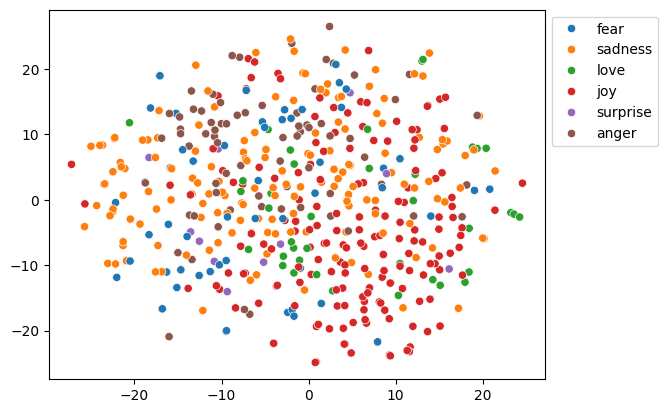

In [30]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np


tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['embeddings'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['label'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))


In [66]:

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df['embeddings'], df["label"],test_size=0.15)

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x.to_list())
test_x = scaler.transform(test_x.to_list())

In [68]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(train_x, train_y.to_list())


print(f"Precision: {100*np.mean(clf.predict(test_x) == test_y.to_list()):.2f}%")

Precision: 64.47%


In [69]:
# classify a single example by myself- abhishek singh
text = "I am so happy"
clf.predict([get_text_embedding(text)]).item()

'joy'

In [70]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=24, max_iter=1000)
model.fit(df['embeddings'].to_list())
df["cluster"] = model.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [72]:
print(*df[df.cluster==2].text.head(3), sep='\n')

ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing
i have officially graduated im not feeling as ecstatic as i thought i would
i needed to show me that i really am integrating and making connections here since i had been feeling pretty homesick the week before
